<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/training_separated(LSTM_%2B_GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Webpage Detection Model (separated)**

## **Connect to Drive and Github responsitory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
Updating files: 100% (75/75), done.
HEAD is now at 8af2080 Fix something 20_11


## **Load dataset**

In [ ]:
import h5py
import tensorflow as tf

In [ ]:
def load_url_dataset(file_path, batch_size=1024):
    with h5py.File(file_path, 'r') as f:
        url_data = f['url']
        label_data = f['label']

        num_samples = label_data.shape[0]

        dataset = tf.data.Dataset.from_tensor_slices((
            (
                tf.convert_to_tensor(url_data, dtype=tf.int32),
            ),
            tf.convert_to_tensor(label_data, dtype=tf.int32)
        ))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## **Create models functions**

### **Create URL model using LSTM**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

In [ ]:
def create_url_lstm_model(vocab_size, max_words, embed_dim, num_lstm_layers=1,
                          lstm_units=128, dropout=0.1, dense_dim=128, l2_reg=5e-4):
    inputs = keras.Input(shape=(max_words,), dtype=tf.int32)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_words)(inputs)

    for _ in range(num_lstm_layers):
        x = layers.LSTM(lstm_units, return_sequences=True, dropout=dropout,
                        kernel_regularizer=regularizers.l2(l2_reg))(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim // 2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    url_lstm_model = keras.Model(inputs=inputs, outputs=outputs)
    return url_lstm_model

### **Create URL model using GRU**

In [ ]:
def create_url_gru_model(vocab_size, max_words, embed_dim, num_gru_layers=1,
                         gru_units=128, dropout=0.1, dense_dim=128, l2_reg=5e-4):
    inputs = keras.Input(shape=(max_words,), dtype=tf.int32)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_words)(inputs)

    for _ in range(num_gru_layers):
        x = layers.GRU(gru_units, return_sequences=True, dropout=dropout,
                       kernel_regularizer=regularizers.l2(l2_reg))(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim // 2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    url_gru_model = keras.Model(inputs=inputs, outputs=outputs)
    return url_gru_model

## **Train model**

In [ ]:
vocab_size = 6000
max_words = 50

url_train_dataset = load_url_dataset('data/train.h5', batch_size=128)
url_val_dataset = load_url_dataset('data/val.h5', batch_size=128)

### **LSTM**

In [ ]:
model = create_url_lstm_model(vocab_size=vocab_size,
                          max_words=max_words,
                          dropout=0.3,
                          embed_dim=128,
                          lstm_units=128,
                          num_lstm_layers=2,
                          dense_dim=128,
                          l2_reg=5e-4)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

checkpoint_filepath = 'models/best_url_lstm_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(url_train_dataset,
                    validation_data=url_val_dataset,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 128)           768000    
                                                                 
 lstm (LSTM)                 (None, 50, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                             

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

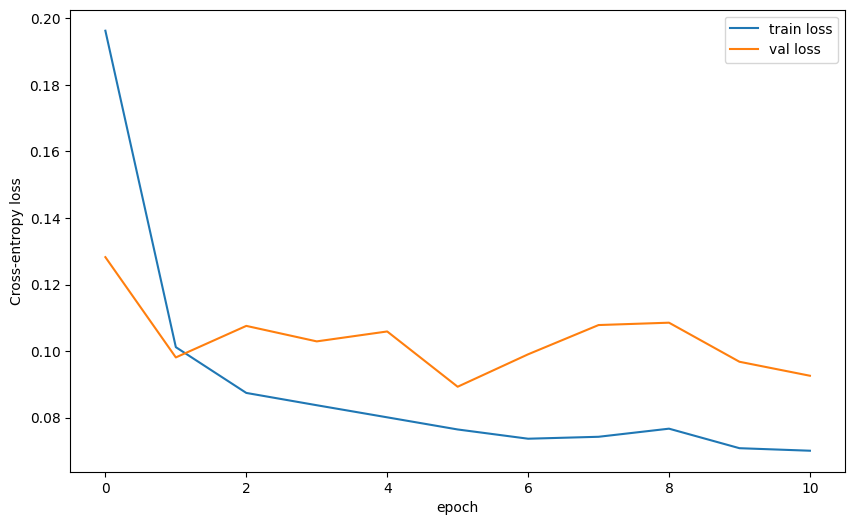

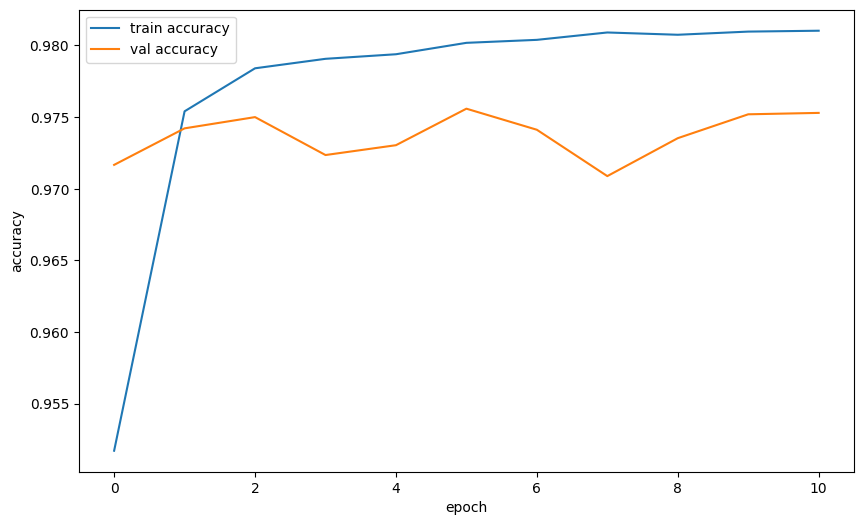

In [ ]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### **GRU**

In [ ]:
model = create_url_gru_model(vocab_size=vocab_size,
                          max_words=max_words,
                          dropout=0.3,
                          embed_dim=128,
                          gru_units=128,
                          num_gru_layers=2,
                          dense_dim=128,
                          l2_reg=5e-4)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

checkpoint_filepath = 'models/best_url_gru_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(url_train_dataset,
                    validation_data=url_val_dataset,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 128)           768000    
                                                                 
 gru (GRU)                   (None, 50, 128)           99072     
                                                                 
 gru_1 (GRU)                 (None, 50, 128)           99072     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                           

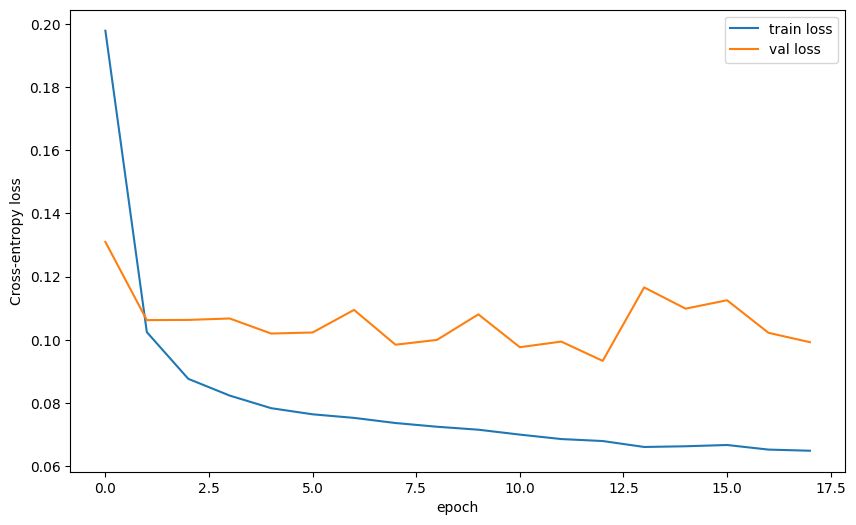

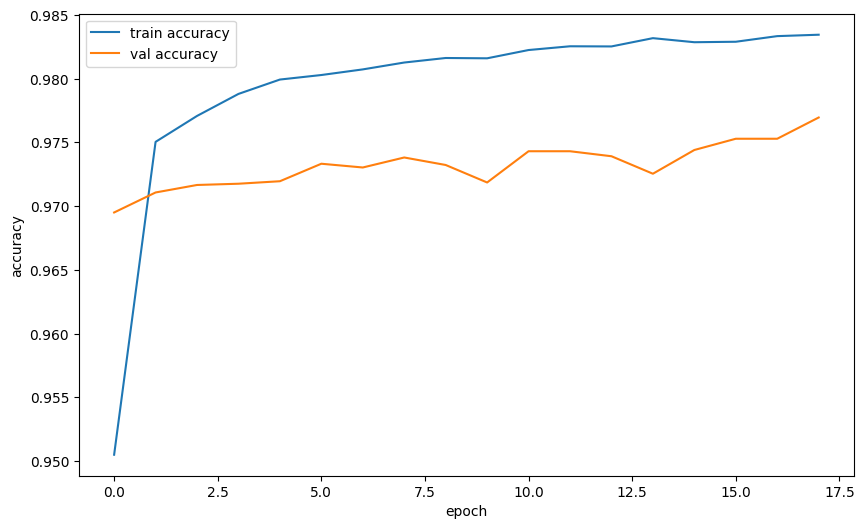

In [ ]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## **Evaluate model**

### **LSTM**

In [ ]:
best_url_lstm_model = keras.models.load_model('models/best_url_lstm_model.keras')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
url_test_dataset = load_url_dataset('data/test.h5', batch_size=128)

results = best_url_lstm_model.evaluate(url_test_dataset, verbose=1)
precision = results[2]
recall = results[3]
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.4f}")

80/80 [==============================] - 7s 70ms/step - loss: 0.0954 - accuracy: 0.9735 - precision: 0.9834 - recall: 0.9633
F1-Score: 0.9733


80/80 [==============================] - 6s 70ms/step


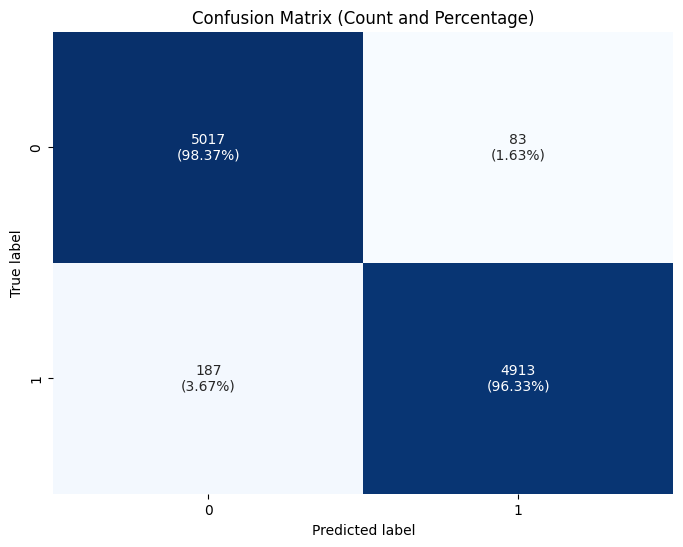

In [ ]:
y_pred_prob = best_url_lstm_model.predict(url_test_dataset)

y_pred = (y_pred_prob >= 0.5).astype(int)
label_test = tf.concat([y for x, y in url_test_dataset], axis=0).numpy()

cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f'{int(count)}\n({percentage:.2%})'
           for count, percentage in zip(row_count, row_percentage)]
           for row_count, row_percentage in zip(cm, cm_percentage)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **GRU**

In [ ]:
best_url_gru_model = keras.models.load_model('models/best_url_gru_model.keras')

In [ ]:
url_test_dataset = load_url_dataset('data/test.h5', batch_size=128)

results = best_url_gru_model.evaluate(url_test_dataset, verbose=1)
precision = results[2]
recall = results[3]
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.4f}")

80/80 [==============================] - 6s 53ms/step - loss: 0.1060 - accuracy: 0.9725 - precision_1: 0.9810 - recall_1: 0.9637
F1-Score: 0.9723


80/80 [==============================] - 5s 52ms/step


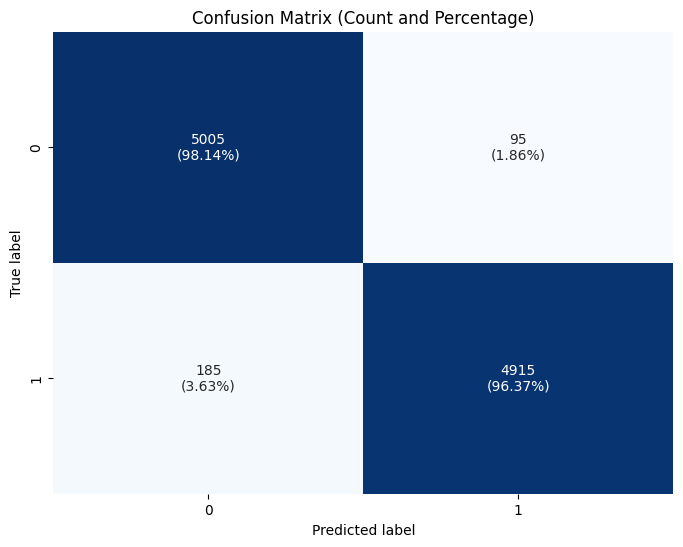

In [ ]:
y_pred_prob = best_url_gru_model.predict(url_test_dataset)

y_pred = (y_pred_prob >= 0.5).astype(int)
label_test = tf.concat([y for x, y in url_test_dataset], axis=0).numpy()

cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f'{int(count)}\n({percentage:.2%})'
           for count, percentage in zip(row_count, row_percentage)]
           for row_count, row_percentage in zip(cm, cm_percentage)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()